In [1]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
def set_seed(seed = 16):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
"""
Cutout is used from https://github.com/uoguelph-mlrg/Cutout
"""
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [4]:
# Original image
normalize =  transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
t0 = transforms.Compose([
                         transforms.ToTensor(),
])
# Crop 
t1 = transforms.Compose([
                         transforms.RandomResizedCrop(32,(0.8,1.0)),
                         transforms.ToTensor(),
                        
])
# Vertical flip
t2 = transforms.Compose([
                         transforms.RandomVerticalFlip(),
                         transforms.ToTensor(),
                    
                         
])
# Horizontal flip
t3 = transforms.Compose([
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                        
])
# Distort
t4 = transforms.Compose([
                         transforms.ColorJitter(3),
                         transforms.ToTensor(),
                   
])
# Rotate
t5 = transforms.Compose([
                         transforms.RandomRotation(270),
                         transforms.ToTensor(),
                      
])
# Cutout
t6 = transforms.Compose([
                         transforms.ToTensor(),
                         Cutout(n_holes=1, length=16),
                         
])
#GaussianBlur
t7 = transforms.Compose([
                         transforms.GaussianBlur(3),
                         transforms.ToTensor(),
                      
])
t136 = transforms.Compose([
                           transforms.RandomResizedCrop(32,(0.8,1.0)),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           Cutout(n_holes=1, length=16)
])

In [5]:
trainingdata = torchvision.datasets.CIFAR10('./CIFAR-10/',train=True,download=True,transform=t136)
testdata = torchvision.datasets.CIFAR10('./CIFAR-10/',train=False,download=True,transform=t0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR-10/cifar-10-python.tar.gz to ./CIFAR-10/
Files already downloaded and verified


In [6]:
print(len(trainingdata))
print(len(testdata))

50000
10000


In [7]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([3, 32, 32]) 6


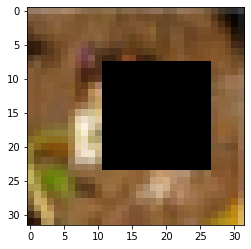

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.permute((1, 2, 0)))
plt.show()

In [9]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

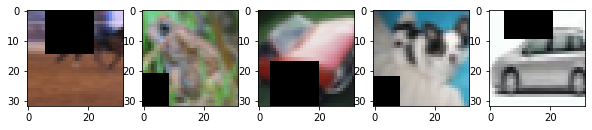

In [10]:

images, labels = iter(trainDataLoader).next()
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].permute((1, 2, 0)))

In [17]:
# Model architecture
class BasicBlock(torch.nn.Module):
  expansion = 1

  def __init__(self, in_planes,planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if (stride != 1 or in_planes != self.expansion*planes):
      self.shortcut = nn.Sequential(nn.Conv2d(in_planes,self.expansion*planes,kernel_size=1,stride=stride,bias=False),
                                    nn.BatchNorm2d(self.expansion*planes)
                                    )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self,block,num_blocks, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_planes = 32
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride = 1, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(32)
    self.layer1 = self._make_layer(block, 32, num_blocks[0], stride = 1)
    self.layer2 = self._make_layer(block, 64, num_blocks[1], stride = 2)
    self.layer3 = self._make_layer(block, 128, num_blocks[2], stride = 2)
    self.layer4 = self._make_layer(block, 256, num_blocks[3], stride = 2)
    self.linear = nn.Linear(256*block.expansion,num_classes)


  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes,planes,stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out,4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock,[3,3,3,3]).cuda()
Loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(ResNet18.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
optimizer = torch.optim.SGD(ResNet18.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)
start_epoch = 0
best_acc = 0


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ResNet18))

4366250


In [19]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

In [20]:
def train(epoch):
  print('\nEpoch: %d' %epoch)
  ResNet18.train()
  train_loss = 0
  correct = 0
  total = 0
  for idx, (images,labels) in enumerate(trainDataLoader):
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = ResNet18(images)
    loss = Loss(outputs,labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predict = outputs.max(1)
    total += labels.size(0)
    correct += predict.eq(labels).sum().item()
  print('Train loss: {:.2f}, Train accuracy:{:.2f} %'.format(train_loss/len(trainDataLoader),correct/total*100))
  train_loss_history.append(train_loss/len(trainDataLoader))
  train_accuracy_history.append(correct/total*100)

In [21]:
def test(epoch):
  ResNet18.eval()
  global best_acc
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, (images,labels) in enumerate(testDataLoader):
      images = images.cuda()
      labels = labels.cuda()
      outputs = ResNet18(images)
      loss = Loss(outputs,labels)
      
      test_loss += loss.item()
      _, predict = outputs.max(1)
      total += labels.size(0)
      correct += predict.eq(labels).sum().item()
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
  print('Test loss: {:.2f}, Test accuracy:{:.2f} %'.format(test_loss/len(testDataLoader),acc))
  print('Best accuracy: {:.2f}%'.format(best_acc))
  test_loss_history.append(test_loss/len(testDataLoader))
  test_accuracy_history.append(acc)

In [22]:
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)
    scheduler.step()
start_epoch += 50


Epoch: 0
Train loss: 1.80, Train accuracy:33.73 %
Test loss: 1.59, Test accuracy:43.08 %
Best accuracy: 43.08%

Epoch: 1
Train loss: 1.40, Train accuracy:49.01 %
Test loss: 1.10, Test accuracy:60.46 %
Best accuracy: 60.46%

Epoch: 2
Train loss: 1.12, Train accuracy:59.83 %
Test loss: 1.07, Test accuracy:63.18 %
Best accuracy: 63.18%

Epoch: 3
Train loss: 0.95, Train accuracy:66.07 %
Test loss: 0.84, Test accuracy:70.91 %
Best accuracy: 70.91%

Epoch: 4
Train loss: 0.83, Train accuracy:70.67 %
Test loss: 0.71, Test accuracy:75.64 %
Best accuracy: 75.64%

Epoch: 5
Train loss: 0.75, Train accuracy:73.71 %
Test loss: 0.71, Test accuracy:75.43 %
Best accuracy: 75.64%

Epoch: 6
Train loss: 0.69, Train accuracy:75.80 %
Test loss: 0.64, Test accuracy:78.08 %
Best accuracy: 78.08%

Epoch: 7
Train loss: 0.64, Train accuracy:77.43 %
Test loss: 0.59, Test accuracy:80.51 %
Best accuracy: 80.51%

Epoch: 8
Train loss: 0.60, Train accuracy:79.00 %
Test loss: 0.54, Test accuracy:81.55 %
Best accuracy:

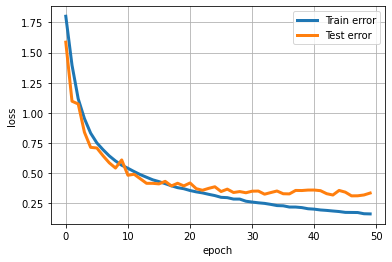

In [23]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

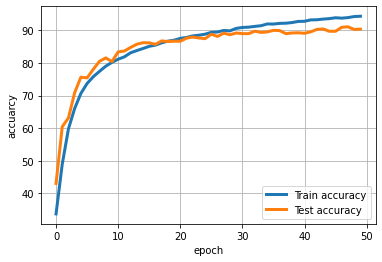

In [24]:
plt.plot(range(len(train_accuracy_history)),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(len(test_accuracy_history)),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuarcy')
plt.grid(True)
plt.legend()

In [25]:
from google.colab import files
torch.save(ResNet18.state_dict(), 'project1_model.pt')

# download checkpoint file
files.download('project1_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# read model file
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet18
model_path = './project1_model.pt'
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>